# Th analysis

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple

import invisible_cities.reco.paolina_functions as plf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.xy_algorithms as xy

from   invisible_cities.database import load_db
from   invisible_cities.core.configure         import configure
from   invisible_cities.core.exceptions import SipmEmptyList
from   invisible_cities.core.exceptions import SipmZeroCharge

from   invisible_cities.io.pmap_io             import load_pmaps
from   invisible_cities.reco                   import pmaps_functions  as pmp
from   invisible_cities.evm.event_model        import Hit, Cluster
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from   invisible_cities.core.system_of_units_c import units

from   invisible_cities.filters.s1s2_filter    import s1s2_filter
from   invisible_cities.filters.s1s2_filter    import s2si_filter
from   invisible_cities.filters.s1s2_filter    import S12Selector

## Reconstruction functions
This functionality will be included in the Penthesilea branch.

In [24]:
DataSiPM        = load_db.DataSiPM(0)
data_xs         = DataSiPM.X.values
data_ys         = DataSiPM.Y.values
#print(DataSiPM)
#print(data_xs)
#print(data_ys)

# histograms to be filled
l_qsipm = []            # all SiPMs
l_qsipm_cluster = []    # all SiPMs within any cluster

l_qsipm_ccenter = []    # the cluster center charges
l_qsipm_qcluster = []   # the cluster energies (same number of entries as l_qsipm_ccenter)

nccenters = 6
l_qsipm_iccenter = []
for n in range(nccenters): l_qsipm_iccenter.append([])

rqmin = 0; rqmax = 70        # charge minima and maxima for charge vs. radius plots
l_q_rlm = []; l_r_rlm = []   # for SiPM charge vs. r within lm_radius
l_q_rnlm = []; l_r_rnlm = [] # for SiPM charge vs. r within new_lm_radius

def barycenter(pos, qs):
    if not len(pos): raise SipmEmptyList
    if sum(qs) == 0: raise SipmZeroCharge
    mu  = np.average( pos           , weights=qs, axis=0)
    std = np.average((pos - mu) ** 2, weights=qs, axis=0)
    return [Cluster(sum(qs), xy(*mu), xy(*std), len(qs))]

def discard_sipms(sis, pos, qs):
    return np.delete(pos, sis, axis=0), np.delete(qs, sis)

def get_nearby_sipm_inds(cs, d, pos, qs):
    """return indices of sipms less than d from (xc,yc)"""
    return np.where(np.linalg.norm(pos - cs, axis=1) <= d)[0]

def corona(pos, qs, Qthr           =  3 * units.pes,
                    Qlm            =  15 * units.pes,
                        lm_radius  = 21.0 * units.mm,
                    new_lm_radius  = 31.0 * units.mm,
                    msipm          =  4):
    """
    corona creates a list of Clusters by
    first , identifying a loc max (gonz wanted more precise than just max sipm)
    second, calling barycenter to find the Cluster given by SiPMs around the max
    third , removing (nondestructively) the sipms contributing to that Cluster
    until there are no more local maxima
    kwargs
    Qthr : SiPMs with less than Qthr pes are ignored
    Qlm  : local maxima must have a SiPM with at least T pes
    lm_radius  : all SiPMs within lm_radius distance from the local max
           SiPM are used (by barycenter) to compute the approximate center
            of the local max.
    new_lm_radius : xs,ys,qs, of SiPMs within new_lm_radius of a local max
           are used by barycenter to compute a Cluster.
    msipm: the minimum number of SiPMs needed to make a cluster
    returns
    c    : a list of Clusters
    """
    c  = []
    # Keep SiPMs with at least Qthr pes
    above_threshold = np.where(qs >= Qthr)[0]
    pos, qs = pos[above_threshold], qs[above_threshold]
    
    
    # While there are more local maxima
    ncenter = 0
    while len(qs) > 0:
        hottest_sipm = np.argmax(qs)       # SiPM with largest Q
        if qs[hottest_sipm] < Qlm: break   # largest Q remaining is negligible

        # find locmax (the baryc of charge in SiPMs less than lm_radius from hottest_sipm)
        within_lm_radius = get_nearby_sipm_inds(pos[hottest_sipm], lm_radius, pos, qs)
        new_local_maximum  = barycenter(pos[within_lm_radius],
                                        qs [within_lm_radius])[0].posxy[0]

        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - pos[hottest_sipm], axis=0)
            if(d < lm_radius and q > rqmin and q < rqmax):
                l_q_rlm.append(q)
                l_r_rlm.append(d)

        # new_lm_radius is an array of the responsive sipms less than
        # new_lm_radius from locmax
        within_new_lm_radius = get_nearby_sipm_inds(new_local_maximum,
                                                    new_lm_radius, pos, qs)
        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - new_local_maximum, axis=0)
            #print("Types are d {0}, q {1}, new_lm_radius {2}, rqmin {3}, rqmax {4}".format(type(d),type(q),type(new_lm_radius),type(rqmin),type(rqmax)))
            if(d < new_lm_radius and q > rqmin and q < rqmax):
                l_q_rnlm.append(q)
                l_r_rnlm.append(d)

        # if there are at least msipms within_new_lm_radius, get the barycenter
        if len(within_new_lm_radius) >= msipm:
            c.extend(barycenter(pos[within_new_lm_radius],
                                qs [within_new_lm_radius]))
            for q in qs[within_new_lm_radius]: l_qsipm_cluster.append(q)
            l_qsipm_ccenter.append(qs[hottest_sipm])
            l_qsipm_qcluster.append(sum(qs))
            if(ncenter < nccenters): l_qsipm_iccenter[ncenter].append(qs[hottest_sipm])
            ncenter += 1

        # delete the SiPMs contributing to this cluster
        pos, qs = discard_sipms(within_new_lm_radius, pos, qs)

    return c

def compute_xy_position(si, slice_no):
    si      = {sipm_no: sipm[slice_no] for sipm_no, sipm in si.items()} #pmp.select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    Qs = np.array(Qs)
    #xs, ys  = data_xs[IDs], data_ys[IDs]
    for q in Qs: l_qsipm.append(q)
    pos = np.array([np.array([x,y]) for x,y in zip(data_xs[IDs],data_ys[IDs])])
    return corona(pos, Qs)

def split_energy(e, clusters):
    if len(clusters) == 1:
        return [e]
    qs = np.array([c.Q for c in clusters])
    return e * qs / np.sum(qs)

## Read the PMaps and construct the hit collection for a given event
This will be performed in the future by Penthesilea.

In [25]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_event(l_X,l_Y,l_Q,l_X0,l_Y0):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(20.0)
    fig.set_figwidth(20.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    plt.scatter(l_X,l_Y,c=l_Q)
    plt.colorbar()
#    for xx,yy,qq in zip(l_X,l_Y,l_Q):
#        r = Ellipse(xy=(xx, yy), width=4., height=4.);
#        r.set_facecolor('0');
#        r.set_alpha(qq);
#        ax1.add_artist(r);

    # place a large blue circle for actual EL points
    ax1.scatter(l_X0,l_Y0,marker='x',s=100,color='red')
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

In [26]:
# Configuration information
tot_Emin = 250000; tot_Emax = 550000
cfile = '/Users/jrenner/IFIC/IC-1/invisible_cities/config/s12_selector_4491.conf'

# read the configuration file
conf = configure(['bar', cfile])
_s1s2_selector = S12Selector(**conf.as_dict)

In [28]:
hitc_evt = []; hitc_mc = []
evtnum_hitc = []
nfiles = 50
print_cut = False
tbl_ri = 0
tot_evts_sum = 0

for ifile in range(nfiles):
    
    print("File {0} of {1}...".format(ifile,nfiles))

    if(ifile < 10): fstr = "00{0}".format(ifile)
    elif(ifile < 100): fstr = "0{0}".format(ifile)
    else: fstr = "{0}".format(ifile)
     
    #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_{0}_0_7bar_pmaps_10000.root.h5".format(ifile)
    filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4491/pmaps/pmaps.gdcsnext.{0}_4491.root.h5".format(fstr)
    #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3913/pmaps/pmaps.gdcsnext.{0}_3913.root.h5".format(fstr)
    #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3755/pmaps/pmaps.gdcsnext.{0}_3755.root.h5".format(fstr)
    if(not os.path.isfile(filename)):
        print("File {0} does not exist. Skipping.".format(ifile))
        continue
    try:
        S1s, S2s, S2Sis = load_pmaps(filename)
    except (ValueError, tb.exceptions.NoSuchNodeError):
        print("Empty file {0}. Skipping.".format(ifile))
    event_numbers, timestamps = get_event_numbers_and_timestamps_from_file_name(filename)
    ftbl = tb.open_file(filename,'r')

    tot_evts_sum += len(event_numbers)
    print("... {0} events in file ({1} total)".format(len(event_numbers), tot_evts_sum))
    for evt_number, evt_time in zip(event_numbers,timestamps):
        #print("Processing event {0}".format(evt_number))
        hitc = []

        s1   = S1s  .get(evt_number, {})
        s2   = S2s  .get(evt_number, {})
        s2si = S2Sis.get(evt_number, {})

        if(not s1 or not s2 or not s2si): continue
        if(len(s2.s2d) != len(s2si.s2sid)): continue
        #print(type(s2si))
        #print(s2.s2d.keys())
        #print(s2si.s2sid.keys())
        
        f1 = s1s2_filter(_s1s2_selector, s1, s2, s2si)
        f2 = s2si_filter(s2si)
        if not f1 or not f2:
            continue

        esum = sum([sum(earr) for pnum,(tarr,earr) in sorted(s2.s2d.items())])
    
        if(not (tot_Emin <= esum <= tot_Emax)):
            if(print_cut): print("Did not make energy cuts...")
        else:
            t, e = next(iter(s1.s1d.values()))
            S1t  = t[np.argmax(e)]
            #S2, Si = rebin_s2(S2, Si)

            npeak = 0
            for peak_no, (t_peak, e_peak) in sorted(s2.s2d.items()):
                si = s2si.s2sid[peak_no]
                e_left = 0
                for slice_no, (t_slice, e_slice) in enumerate(zip(t_peak, e_peak)):
                    #print("Slice number {0}".format(slice_no))
                    clusters = compute_xy_position(si, slice_no)
                    #print("Computed pos")
                    if(len(clusters) == 0):
                        e_left += e_slice
                    else:
                        es       = split_energy(e_slice + e_left, clusters)
                        z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0
                        for c, e in zip(clusters, es):
                            hit       = Hit(peak_no,c,z,e)
                            #print("hit at ({0},{1},{2};{3})".format(hit.X,hit.Y,hit.Z,hit.E))
                            #print("hit at ({0},{1},{2};{3})".format(hit.pos[0],hit.pos[1],hit.pos[2],hit.E))
                            hitc.append(hit)
                        e_left = 0
                if(len(hitc) > 0 and e_left > 0):
                    hitc[-1].energy += e_left
                npeak += 1
                
            hitc_evt.append(hitc)
            evtnum_hitc.append(evt_number)
            
            # record MC information if available
            if(ftbl.__contains__('/MC')):
                hitcm = []
                mctbl = ftbl.root.MC.MCTracks
                while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['event_indx'] != evt_number):
                    tbl_ri += 1
                while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['event_indx'] == evt_number):
                    hpos = mctbl[tbl_ri]['hit_position']
                    henergy = mctbl[tbl_ri]['hit_energy']
                    hit = Hit(hpos[0],hpos[1],hpos[2],henergy)
                    hitcm.append(hit)
                    tbl_ri += 1
                hitc_mc.append(hitcm)

    ftbl.close()
print("Produced hit collections for {0} events ({1} events in MC truth).".format(len(hitc_evt),len(hitc_mc)))

File 0 of 50...
... 82 events in file (82 total)
File 1 of 50...
... 48 events in file (130 total)
File 2 of 50...
... 33 events in file (163 total)
File 3 of 50...
... 112 events in file (275 total)
File 4 of 50...
... 112 events in file (387 total)
File 5 of 50...
... 29 events in file (416 total)
File 6 of 50...
... 1 events in file (417 total)
File 7 of 50...
... 7 events in file (424 total)
File 8 of 50...
... 13 events in file (437 total)
File 9 of 50...
... 87 events in file (524 total)
File 10 of 50...
... 45 events in file (569 total)
File 11 of 50...
... 111 events in file (680 total)
File 12 of 50...
... 25 events in file (705 total)
File 13 of 50...
... 112 events in file (817 total)
File 14 of 50...
... 84 events in file (901 total)
File 15 of 50...
... 111 events in file (1012 total)
File 16 of 50...
... 105 events in file (1117 total)
File 17 of 50...
... 62 events in file (1179 total)
File 18 of 50...
... 1 events in file (1180 total)
File 19 of 50...
... 100 events in 

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


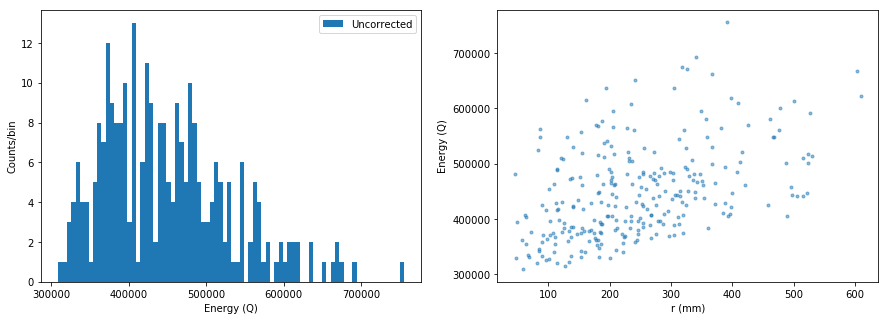

In [44]:
# energy spectrum
e_spec = []; ecorr_spec = []; emc_spec = []; r_spec = []; z_spec = []
for ee in range(len(hitc_evt)):
    evt_E = sum([hh.E for hh in hitc_evt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[ee]])
    if(len(hitc_evt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(ee < len(hitc_mc)): evt_Emc = sum([hh.E for hh in hitc_mc[ee]])
    hr = np.array([np.sqrt(hh.X**2 + hh.Y**2) < 120. for hh in hitc_evt[ee]])
    if(evt_E > 0): #hr.all()):
        e_spec.append(evt_E)
        r_spec.append(evt_R)
        z_spec.append(evt_Z)
        ecorr_spec.append(evt_E/np.exp(-evt_Z/1200))
    emc_spec.append(evt_Emc)

e_spec = np.array(e_spec)

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(ecorr_spec,bins=80,label='Uncorrected')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(122)
plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('r (mm)')
plt.ylabel('Energy (Q)')

# Paolina analysis

In [ ]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([20,20,20],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm

In [ ]:
# run Paolina for many events
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []
for nevt in range(len(hitc_evt)):
    
    hitc = hitc_evt[nevt]
    if(len(hitc) < 2): continue
    print("Track {0} with {1} hits...".format(nevt,len(hitc)))
        
    #for h in hitc:
    #    print("Hit ({0},{1},{2},{3})".format(h.pos[0],h.pos[1],h.pos[2],h.E))
    evt_E = sum([hh.E for hh in hitc])
    #print("Event {0} with total energy {1}".format(nevt,evt_E))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    itmax = np.argmax([len(t) for t in trks])
    #print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # add distribution information (event-scale)
    l_eblob1.append(Eblob1)
    l_eblob2.append(Eblob2)
    
    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)

In [ ]:
# Plot Eblob1 vs. Eblob2
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

#cuts_blob = ((dist_cuts) & (l_dblobs > trklen_low))
#((l_etotcorr > Ecut_low) & (l_etotcorr < Ecut_high) & 
#             (l_eblob1 > Ecut_low_blobs) & (l_eblob2 < Ecut_high_blobs) & 
#             (l_dblobs > trklen_low))
#print(l_hcindex[np.nonzero(cuts_blob & (l_eblob1 > 500))])

# create the x-y projection
#hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_blob], l_eblob2[cuts_blob], normed=False, bins=(12, 12))
hxy, xxy, yxy = np.histogram2d(l_eblob1, l_eblob2, normed=False, bins=(25, 25))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
plt.xlabel("Eblob2 (Q)")
plt.ylabel("Eblob1 (Q)")
#plt.xlim([Ecut_low_blobs,max(l_eblob2[cuts_blob])])
#plt.ylim([Ecut_low_blobs,max(l_eblob1[cuts_blob])])
plt.colorbar()

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(e_spec[l_eblob1 < 20000],bins=30,label='Single-track')
plt.hist(e_spec[l_eblob1 > 20000],bins=40,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

In [ ]:
nevt = 0
hitc = hitc_evt[nevt]
print("Running Paolina for event {0} (event number {1})".format(nevt,evtnum_hitc[nevt]))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E))

voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
for t in trks:
    etrk = sum([vox.E for vox in t.nodes()])
    trk_energies.append(etrk)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
if(len(eblobs) > 1):
    Eblob1, Eblob2 = next(iter_eblobs), next(iter_eblobs)
else:
    Eblob1 = Eblob2 = next(iter_eblobs)

# get the extremes
distances = plf.shortest_paths(trks[itmax])
exts = plf.find_extrema(distances)
iter_exts = iter(exts)
if(len(exts) > 1):
    a,b = next(iter_exts),next(iter_exts)
else:
    a = b = next(iter_exts)
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E)

vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132);
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2);
cbp2.set_label('Energy (Q)');
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2})".format(a.pos[0],a.pos[1],a.pos[2]))
print("Extreme1 at ({0},{1},{2})".format(b.pos[0],b.pos[1],b.pos[2]))

In [ ]:
# plot the clusters in 3D
carr_x = []; carr_y = []; carr_z = []; carr_c = []
for cc in hitc:
    if(cc.E > 1):
        carr_x.append(cc.X)
        carr_y.append(cc.Y)
        carr_z.append(cc.Z)
        carr_c.append(cc.E)

mcarr_x = []; mcarr_y = []; mcarr_z = []; mcarr_c = []
if(nevt < len(hitc_mc)):
    hitcm = hitc_mc[nevt]
    for cc in hitcm:
        mcarr_x.append(cc.X)
        mcarr_y.append(cc.Y)
        mcarr_z.append(cc.Z)
        mcarr_c.append(cc.E)
    
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(25.0)

# true track
ax1 = fig.add_subplot(131, projection='3d')
sc3d = ax1.scatter(mcarr_x,mcarr_y,mcarr_z,marker='s',cmap='jet',c=mcarr_c)
xst, xen = ax1.get_xlim(); ax1.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax1.get_ylim(); ax1.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax1.get_zlim(); ax1.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_zlabel("z (mm)")
ax1.set_title("True Track")
lb_x = ax1.get_xticklabels()
lb_y = ax1.get_yticklabels()
lb_z = ax1.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (MeV)')

# reconstructed clusters
ax2 = fig.add_subplot(132, projection='3d')
sc3d = ax2.scatter(carr_x,carr_y,carr_z,marker='s',cmap='jet',c=carr_c)
xst, xen = ax2.get_xlim(); ax2.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax2.get_ylim(); ax2.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax2.get_zlim(); ax2.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")
ax2.set_zlabel("z (mm)")
ax2.set_title("Reconstructed Clusters")
lb_x = ax2.get_xticklabels()
lb_y = ax2.get_yticklabels()
lb_z = ax2.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

# Paolina track
ax3 = fig.add_subplot(133, projection='3d')
sc3d = ax3.scatter(varr_x,varr_y,varr_z,marker='s',cmap='jet',c=varr_c)
xst, xen = ax3.get_xlim(); ax3.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax3.get_ylim(); ax3.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax3.get_zlim(); ax3.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")
ax3.set_zlabel("z (mm)")
ax3.set_title("Paolina Track")
lb_x = ax3.get_xticklabels()
lb_y = ax3.get_yticklabels()
lb_z = ax3.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(trk_energies,bins=200)
ax1.set_title("Paolina track energies")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_xlim([0,10000])
#ax2.set_yscale("log")

nn = 0
for ee,te in zip(evtnum_hitc,trk_energies):
    if(400 < te < 20000):
        print("Event {0} (number {1})".format(nn,ee))
    nn += 1

## Histograms from the Corona step

In [ ]:
# total charge
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# charge histogram
#ax1 = fig.add_subplot(121);
#plt.hist(l_qsipm,bins=200)
#ax1.set_title("Charge in all SiPMs in PMaps")
#ax1.set_xlabel("Charge (Q)")
#ax1.set_ylabel("Counts/bin")
#ax1.set_yscale("log")

# charge vs. cluster energy
ax2 = fig.add_subplot(111);
plt.scatter(l_qsipm_ccenter,l_qsipm_qcluster,marker='.',s=0.5)
ax2.set_title("Central charge of cluster vs. total charge of cluster")
ax2.set_xlabel("Central charge (Q)")
ax2.set_ylabel("Cluster charge (Q)")
#ax1.set_yscale("log")

In [ ]:
# cluster charges
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
plt.hist(l_qsipm_cluster,bins=200)
ax1.set_title("Charge in all SiPMs in clusters")
ax1.set_xlabel("Charge (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
#hxy, xxy, yxy = np.histogram2d(l_etotcorr[dist_cuts], l_zavg[dist_cuts], normed=False, bins=(30, 30))
#extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
#sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
plt.hist(l_qsipm_ccenter,bins=200)
ax2.set_title("Central cluster charge")
ax2.set_xlabel("Charge (Q)")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")

In [ ]:
# cluster charge vs. radial distance from local maxima
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
#plt.scatter(l_r_rlm,l_q_rlm,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rlm, l_r_rlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp1 = plt.colorbar(sp1)
ax1.set_title("SiPM charge vs. radius from initial local maximum")
ax1.set_xlabel("Radial distance (mm)")
ax1.set_ylabel("SiPM charge")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rnlm, l_r_rnlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp2 = plt.colorbar(sp2)
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
#plt.scatter(l_r_rnlm,l_q_rnlm,marker='.')
ax2.set_title("SiPM charge vs. radius from second local maximum")
ax2.set_xlabel("Radial distance (mm)")
ax2.set_ylabel("SiPM charge")

In [ ]:
# cluster charges
fig = plt.figure(4);
fig.set_figheight(15.0);
fig.set_figwidth(15.0);

# charge histograms for max clusters
for n in range(nccenters):
    splt_str = "32{0}".format(n+1)
    ax1 = fig.add_subplot(splt_str);
    plt.hist(l_qsipm_iccenter[n],bins=200)
    ax1.set_title("SiPM central charge for cluster {0}".format(n))
    ax1.set_xlabel("Charge (Q)")
    ax1.set_ylabel("Counts/bin")
    ax1.set_yscale("log")
    print("{0} entries for cluster {1}".format(len(l_qsipm_iccenter[n]),n))

# Old misc. code

In [ ]:
# plot a PMap slice
slice_no = 14
evt_no = 313
peak_no = 0

filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_0_0_7bar_pmaps_10000.root.h5"
try:
    S1s, S2s, S2Sis = load_pmaps(filename)
except (ValueError, tb.exceptions.NoSuchNodeError):
    print("Empty file {0}. Skipping.".format(ifile))

S2 = S2s  .get(evt_no, {})
S1 = S1s  .get(evt_no, {})
Si = S2Sis.get(evt_no, {})
si = Si[peak_no]

t, e = next(iter(S1.values()))
S1t  = t[np.argmax(e)]

t_slice = S2[0][0][slice_no]
z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0

clusters = compute_xy_position(si, slice_no)
print("Found {0} clusters".format(len(clusters)))

x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("cluster ({0},{1},{2})".format(c.pos[0],c.pos[1],z))
    
xvals = []; yvals = []; qvals = []
for s in si.items():
    xvals.append(data_xs[s[0]])
    yvals.append(data_ys[s[0]])
    qvals.append(s[1][slice_no])
    #print(s[1])
    
plot_test_event(xvals,yvals,qvals,x0vals,y0vals)

# Plot the generated correction factors

In [ ]:
corr_file_MC = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/mcKr.corr"
corr_file_data_dnn = "/Users/jrenner/IFIC/IC-1/invisible_cities/cities/corr_r4236.h5" 
corr_file_data = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b30.corr"
fcorr_MC = tb.open_file(corr_file_MC,'r')
fcorr_data = tb.open_file(corr_file_data,'r')
fcorr_data_dnn = tb.open_file(corr_file_data_dnn,'r')

mcorr_x = []; mcorr_y = []; mcorr_fs = []; mcorr_us = []; mcorr_nevt = []
mxyc = fcorr_MC.root.Corrections.XYcorrections
for r in range(len(mxyc)):
    mcorr_x.append(mxyc[r]['x'])
    mcorr_y.append(mxyc[r]['y'])
    mcorr_fs.append(mxyc[r]['factor'])
    mcorr_us.append(mxyc[r]['uncertainty'])
    mcorr_nevt.append(mxyc[r]['nevt'])
mcorr_x = np.array(mcorr_x)
mcorr_y = np.array(mcorr_y)
mcorr_fs = np.array(mcorr_fs)
mcorr_us = np.array(mcorr_us)
mcorr_nevt = np.array(mcorr_nevt)
maxf_mc = np.max(mcorr_fs)
print("Total MC stats = {0}".format(np.sum(mcorr_nevt)))

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr_data.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf_data = np.max(corr_fs)
print("Total data stats = {0}".format(np.sum(corr_nevt)))

dcorr_x = []; dcorr_y = []; dcorr_fs = []; dcorr_us = []; dcorr_nevt = []
dxyc = fcorr_data_dnn.root.Corrections.XYcorrections
for r in range(len(dxyc)):
    dcorr_x.append(dxyc[r]['x'])
    dcorr_y.append(dxyc[r]['y'])
    dcorr_fs.append(dxyc[r]['factor'])
    dcorr_us.append(dxyc[r]['uncertainty'])
    dcorr_nevt.append(dxyc[r]['nevt'])
dcorr_x = np.array(dcorr_x)
dcorr_y = np.array(dcorr_y)
dcorr_fs = np.array(dcorr_fs)
dcorr_us = np.array(dcorr_us)
dcorr_nevt = np.array(dcorr_nevt)
maxf_data_dnn = np.max(dcorr_fs)
print("Total data DNN stats = {0}".format(np.sum(dcorr_nevt)))

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(18.0);

# correction factor (MC)
ax1 = fig.add_subplot(331);
ax1.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax1.set_title("Correction factor (MC, DST)")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(332)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error (MC, DST)")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(333)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events (MC, DST)")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

ax4 = fig.add_subplot(334)
ax4.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax4.set_title("Correction factor (run 4236, DST)")
ax4.set_xlabel("x (mm)")
ax4.set_ylabel("y (mm)")

ax5 = fig.add_subplot(335)
ax5.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax5.set_title("Correction factor error (run 4236, DST)")
ax5.set_xlabel("x (mm)")
ax5.set_ylabel("y (mm)")

ax6 = fig.add_subplot(336)
ax6.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax6.set_title("Correction factor # events (run 4236, DST)")
ax6.set_xlabel("x (mm)")
ax6.set_ylabel("y (mm)")

ax7 = fig.add_subplot(337)
ax7.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_data_dnn,maxf_mc,maxf_data))
plt.colorbar()
ax7.set_title("Correction factor (run 4236, DNN)")
ax7.set_xlabel("x (mm)")
ax7.set_ylabel("y (mm)")

ax8 = fig.add_subplot(338)
ax8.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_us, cmap='jet')
plt.colorbar()
ax8.set_title("Correction factor error (run 4236, DNN)")
ax8.set_xlabel("x (mm)")
ax8.set_ylabel("y (mm)")

ax9 = fig.add_subplot(339)
ax9.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_nevt, cmap='jet')
plt.colorbar()
ax9.set_title("Correction factor # events (run 4236, DNN)")
ax9.set_xlabel("x (mm)")
ax9.set_ylabel("y (mm)")

#ax1 = fig.add_subplot(121);
#extent1 = [-215., 215., -215., 215]
#sp2 = plt.imshow(h2d, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)
#ax2 = fig.add_subplot(122)
#sp2 = plt.imshow(h2d_err, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)

fcorr_MC.close()
fcorr_data.close()

In [ ]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236.corr"
fcorr = tb.open_file(corr_file,'r')

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
    
fig = plt.figure(4);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor fs
ax1 = fig.add_subplot(121);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(122)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us)
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

In [ ]:
# Initial look at run 4264
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4264/dst/dst_4264.root.h5','r')

# plot the S2 spectrum
s2arr = fn.root.DST.Events[:]['S2e']

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(s2arr,bins=500)
lnd = plt.legend(loc=1)
plt.xlabel('Energy')
plt.ylabel('Counts/bin')
#plt.xlim([1000,40000])